In [1]:
R.version

               _                                
platform       x86_64-w64-mingw32               
arch           x86_64                           
os             mingw32                          
crt            ucrt                             
system         x86_64, mingw32                  
status                                          
major          4                                
minor          4.2                              
year           2024                             
month          10                               
day            31                               
svn rev        87279                            
language       R                                
version.string R version 4.4.2 (2024-10-31 ucrt)
nickname       Pile of Leaves                   

# 1. Initialization

In [4]:
# PACKAGES & CONSTANTS DECLARATIONS #
#####################################

# Function to install missing packages
InstallPackages <- function(oPackageList) {
  for (sPackage in oPackageList) {
    if (!require(sPackage, character.only = TRUE)) {
      install.packages(sPackage, repos = "http://cran.r-project.org")
      library(sPackage, character.only = TRUE)
    }
  }
}

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# List of required packages
oRequiredPackages <- c("sfsmisc","sparsepca", "elasticnet","reshape2", "ggplot2", "tidyr", "dplyr", "MASS", "Matrix", "stats", "doParallel")

# Install missing packages
InstallPackages(oRequiredPackages)

global_iRandomSeed <- 13654
set.seed(global_iRandomSeed)  # for reproducibility

# Constants for data dimensions
N_OBSERVATIONS <- 600
N_VARIABLES <- 1200
global_UseParallelization = 1
global_bZeroImputationBehaviour = 1
global_TrainTestRatio = 0.7

# If needed, enable CPU cores parallelization #
if (global_UseParallelization == 1) {
    library(doParallel)
    global_iCoreNumber <- detectCores() - 1
    registerDoParallel(cores = global_iCoreNumber)
}

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-09 10:35:46"


Le chargement a nécessité le package : sfsmisc

Le chargement a nécessité le package : sparsepca

Le chargement a nécessité le package : elasticnet

Le chargement a nécessité le package : lars

Loaded lars 1.3


Registered S3 method overwritten by 'elasticnet':
  method     from     
  print.spca sparsepca


Attachement du package : 'elasticnet'


L'objet suivant est masqué depuis 'package:sparsepca':

    spca


Le chargement a nécessité le package : reshape2

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : tidyr


Attachement du package : 'tidyr'


L'objet suivant est masqué depuis 'package:reshape2':

    smiths


Le chargement a nécessité le package : dplyr


Attachement du package : 'dplyr'


L'objet suivant est masqué depuis 'package:sfsmisc':

    last


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union


Le chargement 

[1] "Current Time : 2024-12-09 10:35:47"
[1] "Duration : 1.194 seconds"


# 2. Data Generation

In [7]:
Get_Preprocessed_Data <- function(oDataSet) {
  Get_the_Mode <- function(x) {
    ux <- unique(na.omit(x))
    ux[which.max(tabulate(match(x, ux)))]
  }

  if (global_bZeroImputationBehaviour == 1) {
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else((is.na(.) | (. == 0)), mean(., na.rm = TRUE), .)))
  } else if (global_bZeroImputationBehaviour == 0) {    
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else(is.na(.), mean(., na.rm = TRUE), .)))
  }

  # Replace NA by the mode.
  oDataSet <- oDataSet %>%
    mutate(across(where(is.factor), ~ if_else(is.na(.), Get_the_Mode(.), .)))

  return(oDataSet)
}

In [154]:
# DATASET 03 => Breast Cancer                  #
################################################

# Based on thos article : https://www.bioconductor.org/packages/devel/bioc/vignettes/PCAtools/inst/doc/PCAtools.html#download-the-package-from-bioconductor

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}
BiocManager::install(c("Biobase", "GEOquery"))

library(Biobase)
library(GEOquery)

# Loading data from GEO
gset <- getGEO('GSE2990', GSEMatrix = TRUE, getGPL = FALSE)

# Extraction de la matrice d'expression
mat <- exprs(gset[[1]])

# Cleaning Affymetrix probes
mat <- mat[-grep('^AFFX', rownames(mat)),]

# Extraction metadata
idx <- which(colnames(pData(gset[[1]])) %in%
    c('relation', 'age:ch1', 'distant rfs:ch1', 'er:ch1',
      'ggi:ch1', 'grade:ch1', 'size:ch1',
      'time rfs:ch1'))
metadata <- data.frame(pData(gset[[1]])[, idx],
                       row.names = rownames(pData(gset[[1]])))

colnames(metadata) <- c('Study', 'Age', 'Distant.RFS', 'ER', 'GGI', 'Grade',
                        'Size', 'Time.RFS')

metadata$Study <- gsub('Reanalyzed by: ', '', as.character(metadata$Study))
metadata$Age <- as.numeric(gsub('^KJ', NA, as.character(metadata$Age)))
metadata$Distant.RFS <- factor(metadata$Distant.RFS, levels = c(0, 1))
metadata$ER <- factor(gsub('\\?', NA, as.character(metadata$ER)),
                      levels = c(0, 1))
metadata$ER <- factor(ifelse(metadata$ER == 1, 'ER+', 'ER-'),
                      levels = c('ER-', 'ER+'))
metadata$GGI <- as.numeric(as.character(metadata$GGI))
metadata$Grade <- factor(gsub('\\?', NA, as.character(metadata$Grade)),
                         levels = c(1, 2, 3))
metadata$Grade <- gsub(1, 'Grade 1', gsub(2, 'Grade 2', gsub(3, 'Grade 3', metadata$Grade)))
metadata$Grade <- factor(metadata$Grade, levels = c('Grade 1', 'Grade 2', 'Grade 3'))
metadata$Size <- as.numeric(as.character(metadata$Size))
metadata$Time.RFS <- as.numeric(gsub('^KJX|^KJ', NA, metadata$Time.RFS))

discard <- apply(metadata, 1, function(x) any(is.na(x)))
metadata <- metadata[!discard,]

mat <- mat[, which(colnames(mat) %in% rownames(metadata))]

if (!all(colnames(mat) == rownames(metadata))) {
    stop("Les noms des échantillons ne correspondent pas exactement entre les métadonnées et la matrice d'expression.")
}

oDataMatrix <- as.data.frame(mat)

if (!is.null(oDataMatrix)) {
  oDataMatrix <- oDataMatrix[, sapply(oDataMatrix, is.numeric), drop = FALSE]
  oDataMatrix <- as.data.frame(lapply(oDataMatrix, as.double))
  oDataMatrix <- as.data.frame(lapply(oDataMatrix, function(col) as.numeric(as.character(col))))
  if (any(is.na(oDataMatrix))) {
    warning("NA detected after conversion. Rows with NA will be removed.")
    oDataMatrix <- na.omit(oDataMatrix)
  }
} else {
  stop("oDataMatrix is NULL. Please provide a valid dataset.")
}

# !!!!!!!!!! GENOMIC DATA HERE. MATRIX MUST BE INVERTED !!
oDataMatrix <- as.matrix(oDataMatrix)
oDataMatrix <- t(oDataMatrix)

# Preprocessing
oDataMatrix <- as.data.frame(oDataMatrix)                                      
oDataMatrix <- Get_Preprocessed_Data(oDataMatrix)

# Keep only 2500 columns
selected_columns <- sample(1:ncol(oDataMatrix), 2500)
oDataMatrix <- oDataMatrix[, selected_columns]
rownames(oDataMatrix) <- oDataMatrix[, 1]
oDataMatrix <- oDataMatrix[, -1]  # Delete first column
oDataMatrix <- as.data.frame(lapply(oDataMatrix, as.numeric))
oDataMatrix <- as.matrix(oDataMatrix)
                                      
cat("Dimensions Matrix : ", dim(mat), "\n")
head(oDataMatrix)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-09 10:57:11"


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31 ucrt)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'Biobase' 'GEOquery'"
Old packages: 'bit', 'cluster', 'cpp11', 'data.table', 'later', 'promises',
  'quantreg'

Found 1 file(s)

GSE2990_series_matrix.txt.gz

Using locally cached version: C:\Users\gouro\AppData\Local\Temp\RtmpQHdZVx/GSE2990_series_matrix.txt.gz



Dimensions Matrix :  22215 91 


V3048,V12255,V16031,V11029,V7724,V15483,V6391,V5856,V17083,V2808,⋯,V2553,V728,V17890,V8942,V19648,V19278,V19135,V13737,V20827,V5007
7.558354,7.663967,7.204341,6.288661,6.222943,7.798647,6.398558,6.960535,11.43386,7.676059,⋯,8.846662,9.756052,7.373215,8.689883,7.224526,6.686501,7.048803,7.654507,7.480851,10.673005
7.469504,8.233372,7.386354,6.268697,5.847786,7.688862,6.280904,6.744861,11.92943,8.674607,⋯,9.765403,9.850497,7.578987,8.127016,6.937418,6.716195,7.068795,7.142329,7.245276,9.578715
7.405537,8.468667,7.138597,6.160089,5.896715,7.409250,6.276735,7.096081,11.72669,7.553244,⋯,8.760105,9.218898,7.802536,8.438666,7.212803,6.789110,6.861624,6.696320,7.350538,9.888052
7.373715,9.077206,7.158553,6.196957,5.719321,7.511514,6.387771,7.025889,11.98229,8.625543,⋯,9.553286,9.241461,7.777861,7.924504,6.980383,6.836669,6.885990,7.357474,7.304335,9.825168
7.345175,8.029677,7.350165,6.201500,5.937818,7.625838,6.381273,6.968935,11.88073,8.611956,⋯,9.614658,10.193517,7.470767,7.919271,7.035017,6.629685,7.691955,6.834719,7.390913,9.844041
7.246500,7.414631,7.522638,6.415060,6.009829,7.310561,6.378391,7.125998,11.31435,8.697781,⋯,8.475335,8.434255,7.400703,7.901989,7.545936,7.003807,6.707061,6.753762,7.786638,9.396529


[1] "Current Time : 2024-12-09 10:57:22"
[1] "Duration : 11.304 seconds"


In [114]:

head(oDataMatrix)

GSM65752,GSM65753,GSM65755,GSM65757,GSM65758,GSM65760,GSM65761,GSM65762,GSM65763,GSM65764,⋯,GSM65868,GSM65869,GSM65870,GSM65871,GSM65872,GSM65873,GSM65874,GSM65875,GSM65878,GSM65880
11.417945,11.466307,10.843553,11.705501,10.869301,11.065947,11.960048,11.507803,11.001594,10.288300,⋯,11.339789,11.700093,11.173078,11.321648,11.238857,10.972367,11.226179,11.765416,11.537388,11.525479
7.379692,6.915186,7.369199,7.071089,6.910977,6.776827,7.044657,6.695045,6.684117,6.915896,⋯,7.554001,7.670501,7.362108,6.951810,7.264888,7.291469,6.934923,6.938407,7.147455,7.130340
7.993892,7.316317,7.234621,7.489355,7.634307,7.256335,7.242439,7.313722,7.802289,7.178194,⋯,8.095860,7.390571,7.090128,7.097622,7.096999,7.454182,6.927617,7.112679,7.548334,7.506661
9.358754,9.179772,9.242987,9.281594,9.304971,9.518042,9.353926,9.208027,9.276619,9.395631,⋯,9.700273,9.876940,9.803706,9.832048,9.829909,9.918604,9.668749,10.358743,9.775151,9.963190
4.532913,4.447458,4.419171,4.363968,4.366959,4.619477,4.512231,4.443399,4.494221,4.438276,⋯,5.120697,5.055644,4.991288,5.122737,5.081239,5.171156,5.084063,5.174404,4.958959,5.018631
7.647977,8.534378,7.606492,8.227871,8.582203,8.709101,9.043281,8.279555,8.559933,8.672444,⋯,7.899592,8.373722,8.649969,8.258050,8.860578,8.466948,8.373746,9.148830,8.152121,8.290546


# 3. Data Exploration

In [157]:
# Define train and test sets             #
##########################################

iTrainIndices <- sample(1:nrow(oDataMatrix), size = global_TrainTestRatio * nrow(oDataMatrix))
oTrainData <- oDataMatrix[iTrainIndices, ]
oTestData <- oDataMatrix[-iTrainIndices, ]  # Remaining data for testing

In [159]:
dim(oDataMatrix)
dim(oTrainData)
dim(oTestData)

cat("Colunms : ", colnames(oDataMatrix), "\n")

[1]   91 2499

[1]   63 2499

[1]   28 2499

Colunms :  V3048 V12255 V16031 V11029 V7724 V15483 V6391 V5856 V17083 V2808 V1872 V18556 V2030 V15317 V8831 V15759 V7026 V20127 V18762 V2035 V6098 V12825 V19615 V5149 V21743 V20 V10044 V15147 V20899 V22102 V19947 V21299 V11759 V20703 V8644 V5063 V923 V18062 V16194 V779 V12154 V1432 V8402 V4445 V12744 V4269 V1643 V15646 V19407 V16294 V19749 V10491 V18713 V12704 V7135 V11932 V11981 V14643 V21721 V19368 V17356 V16922 V11872 V10314 V8691 V6005 V9669 V49 V3831 V14223 V22210 V4553 V6171 V12026 V1512 V17162 V5720 V5549 V1253 V14281 V17465 V19569 V19227 V3931 V10845 V3619 V5009 V19045 V8315 V20451 V5533 V7974 V13807 V15374 V15659 V2188 V4129 V14960 V15202 V19674 V13660 V7433 V4158 V11036 V11131 V15962 V6911 V20181 V21523 V4841 V224 V10349 V10402 V21442 V1325 V16373 V6166 V11564 V13622 V5016 V9392 V20092 V18312 V20023 V7031 V14709 V3570 V6710 V21194 V12641 V1379 V17658 V19775 V8984 V14635 V10505 V16789 V6250 V15832 V8508 V14619 V8246 V11829 V4948 V21884 V7346 V17352 V17186 V505 V6356 V14586 V10

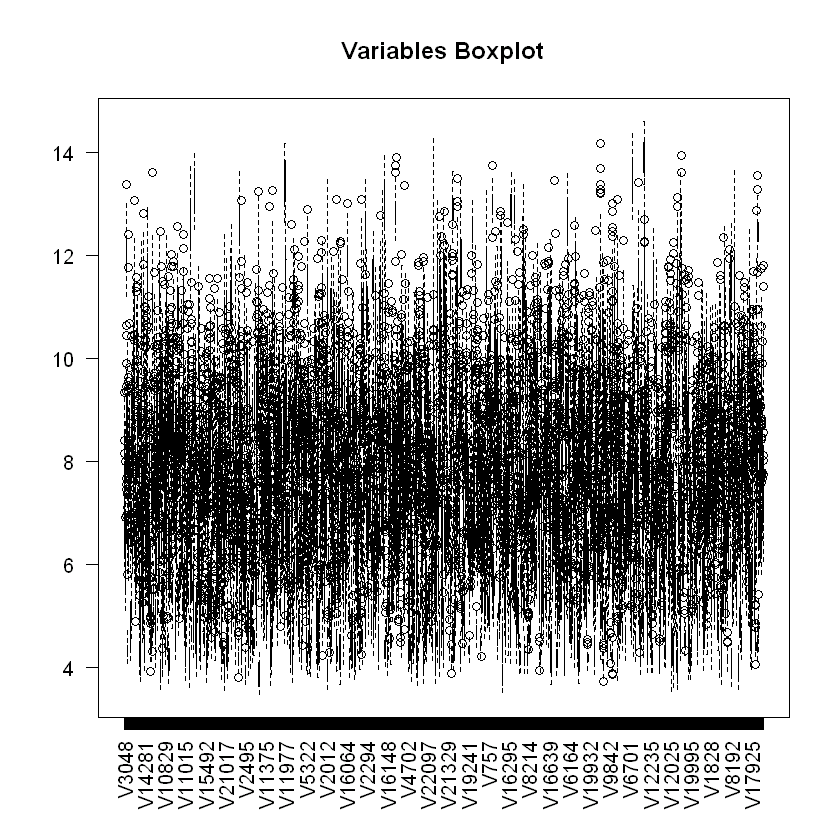

In [161]:
boxplot(oDataMatrix, las = 2, col = rainbow(ncol(oDataMatrix)), main = "Variables Boxplot")

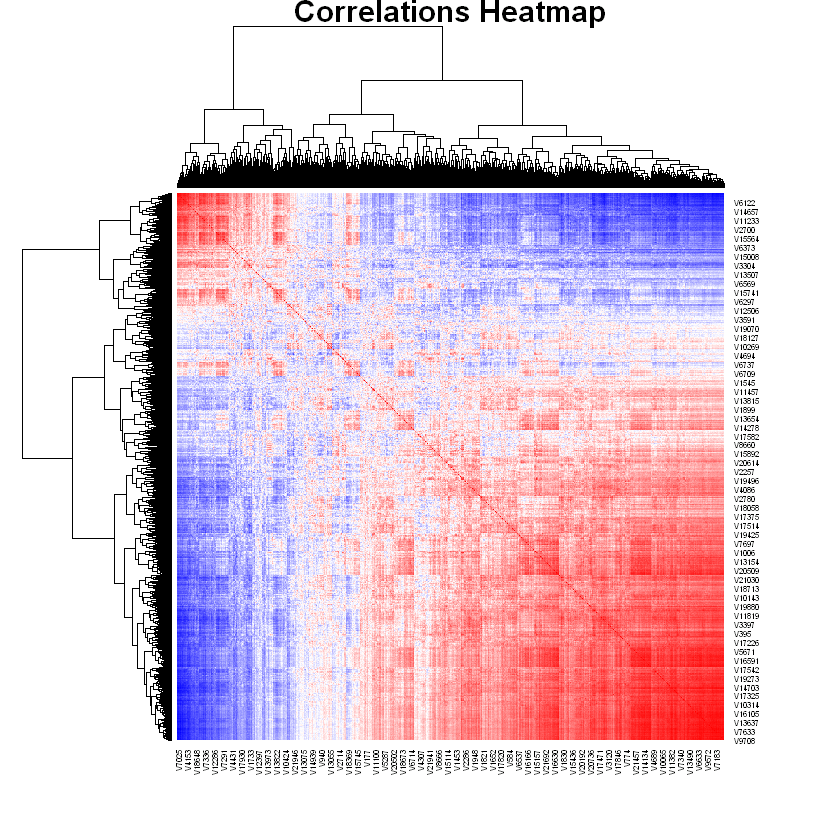

In [18]:
##########################################
# Correlation Matrix                     #
##########################################

cor_matrix <- cor(oDataMatrix)

# Correlations Heatmap
heatmap(cor_matrix, symm = TRUE, col = colorRampPalette(c("blue", "white", "red"))(100),
        main = "Correlations Heatmap")

In [ ]:
##########################################
# Histograms for each variable           #
##########################################

par(mfrow = c(3, 3))  # Arrange plots in a grid
for (col in colnames(oDataMatrix)) {
    hist(oDataMatrix[, col], main = paste("Histogram of", col), xlab = col, col = "lightblue", border = "white")
}
par(mfrow = c(1, 1))  # Reset plot layout


Importance of components:
                          PC1      PC2      PC3     PC4     PC5     PC6     PC7
Standard deviation     29.910 13.57600 11.87719 9.51035 9.03130 7.80488 7.22143
Proportion of Variance  0.358  0.07375  0.05645 0.03619 0.03264 0.02438 0.02087
Cumulative Proportion   0.358  0.43175  0.48820 0.52439 0.55703 0.58141 0.60228
                           PC8    PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     6.62272 6.3041 5.75908 5.46351 5.37213 5.25895 5.01176
Proportion of Variance 0.01755 0.0159 0.01327 0.01194 0.01155 0.01107 0.01005
Cumulative Proportion  0.61983 0.6357 0.64900 0.66095 0.67249 0.68356 0.69361
                          PC15    PC16   PC17    PC18    PC19    PC20    PC21
Standard deviation     4.91674 4.83271 4.7693 4.71468 4.57946 4.44975 4.38939
Proportion of Variance 0.00967 0.00935 0.0091 0.00889 0.00839 0.00792 0.00771
Cumulative Proportion  0.70329 0.71263 0.7217 0.73063 0.73902 0.74694 0.75465
                          PC22

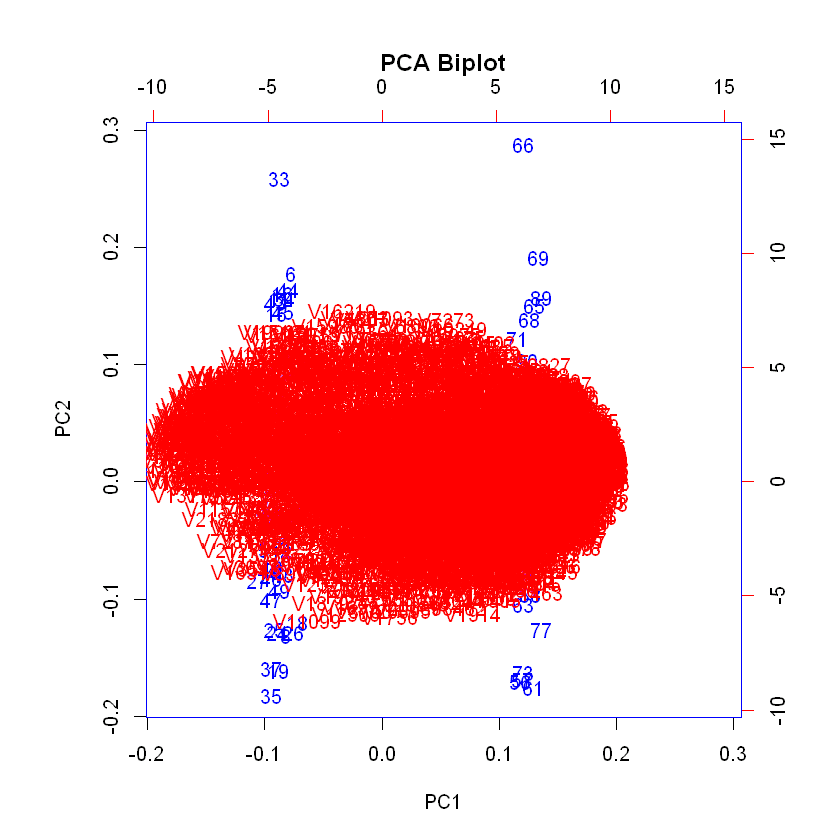

In [163]:
##########################################
# PCA Simple                             #
##########################################

pca_res <- prcomp(oDataMatrix, center = TRUE, scale. = TRUE)

# Summary of principal components
summary(pca_res)

# Biplot of the first two principal components
biplot(pca_res, main = "PCA Biplot", col = c("blue", "red"))


In [ ]:
##########################################
# t-SNE Visualization                    #
##########################################

# Reduce dimensionality using t-SNE and visualize clusters.

if (!requireNamespace("Rtsne", quietly = TRUE)) {
    install.packages("Rtsne")
}
library(Rtsne)

# t-SNE
tsne_res <- Rtsne(oDataMatrix, dims = 2, perplexity = 15)

# Visualize t-SNE results
plot(tsne_res$Y, main = "t-SNE Projection", xlab = "Dim 1", ylab = "Dim 2",
     col = rainbow(length(tsne_res$Y[,1])), pch = 19)

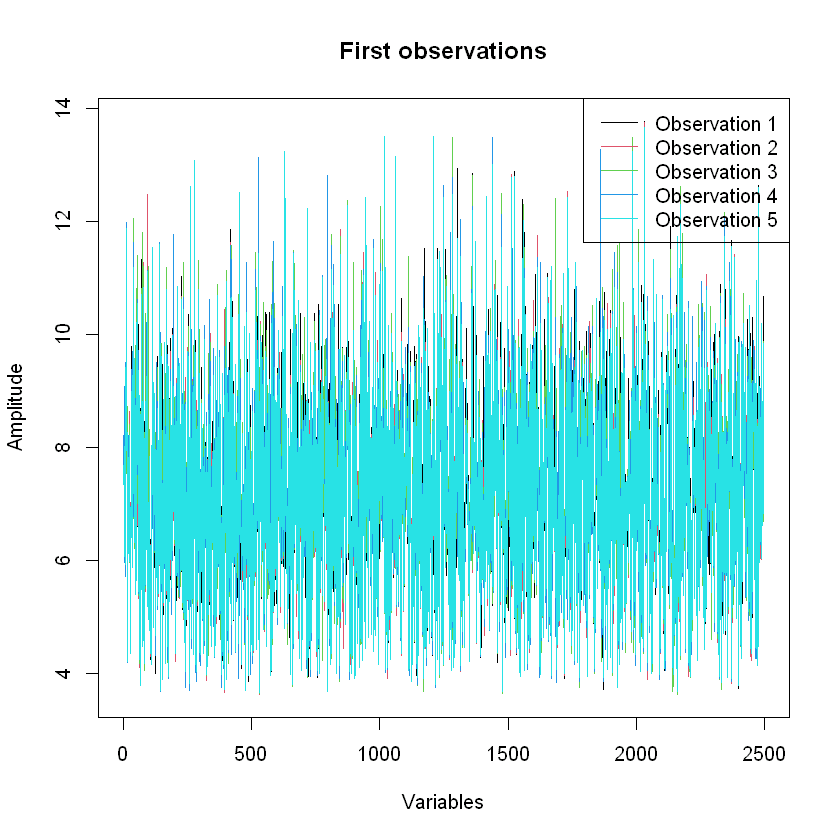

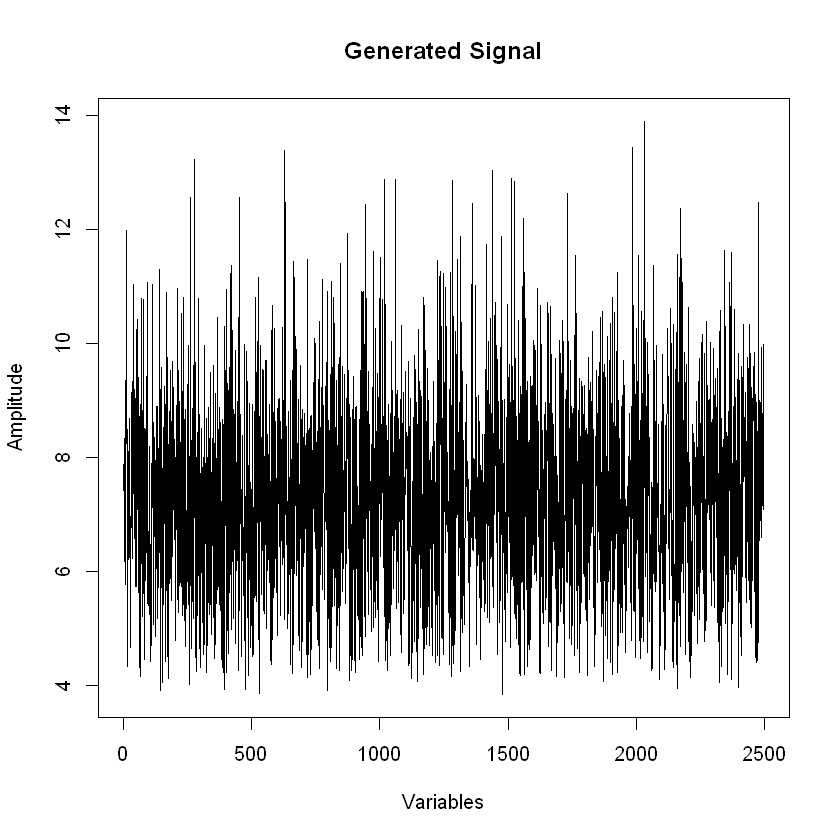

In [165]:
# Ploting first observations             #
##########################################

matplot(t(oDataMatrix[1:5, ]), type = "l", lty = 1, col = 1:5,
        main = "First observations",
        xlab = "Variables", ylab = "Amplitude")
legend("topright", legend = paste("Observation", 1:5), col = 1:5, lty = 1)

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oDataMatrix)

plot(mean_signal, type = "l", main = "Generated Signal", xlab = "Variables", ylab = "Amplitude")

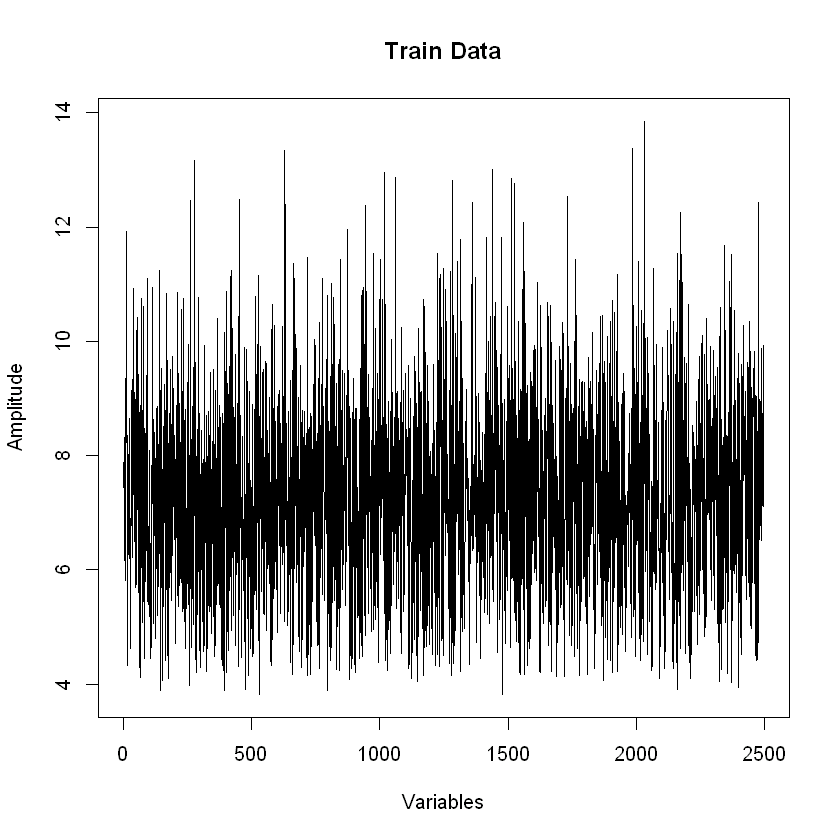

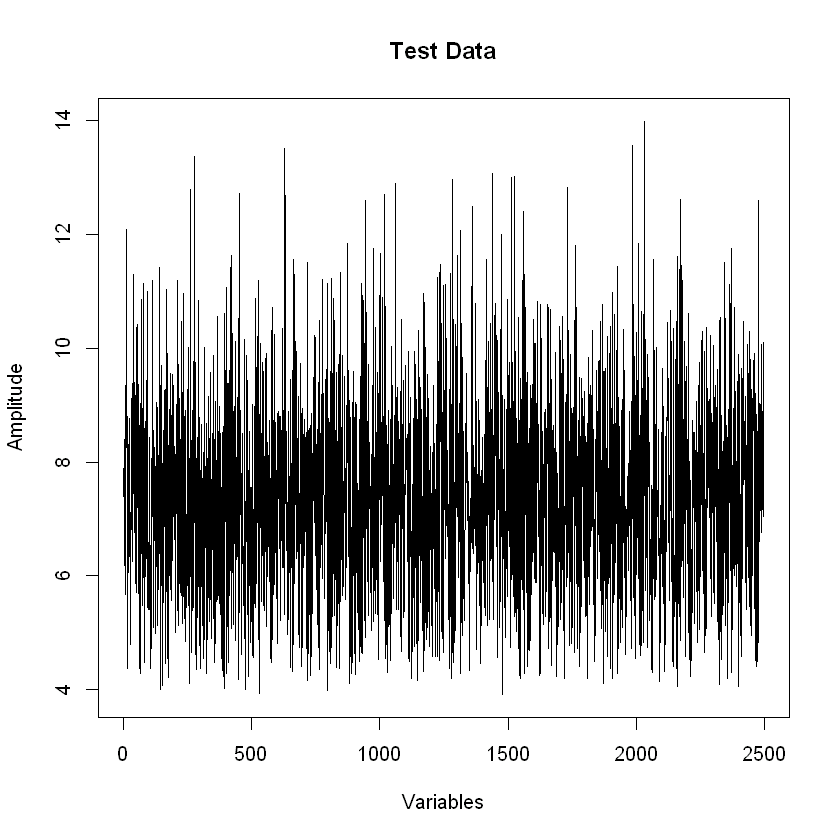

In [167]:
# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oTrainData)

plot(mean_signal, type = "l", main = "Train Data", xlab = "Variables", ylab = "Amplitude")

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oTestData)

plot(mean_signal, type = "l", main = "Test Data", xlab = "Variables", ylab = "Amplitude")

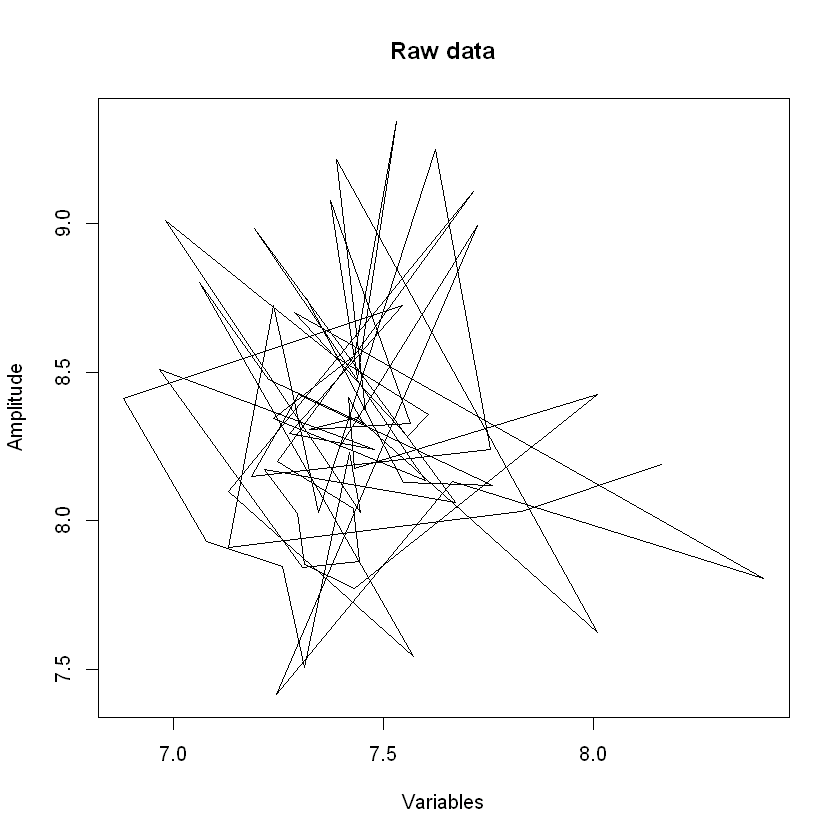

In [169]:
plot(oTrainData, type = "l", main = "Raw data", xlab = "Variables", ylab = "Amplitude")

In [171]:
Analyze_PCA <- function(X, numAxes = 50, explainedVarianceThreshold = 70) {
  pca <- prcomp(X, center = TRUE, scale. = TRUE)
  
  variance <- (pca$sdev^2 / sum(pca$sdev^2)) * 100
  cat(paste0("Variance explained by the first ", numAxes, " axes: ", sum(variance[1:numAxes]), "\n"))
  
  cum_variance <- cumsum(variance)
  
  num_components <- which(cum_variance >= explainedVarianceThreshold)[1]
  cat(paste("Number of principal components:", num_components, "to have", explainedVarianceThreshold, "% of variance\n"))
  
  d <- data.frame(PCAxes = seq_along(variance), Variance = variance, CumulativeVariance = cum_variance)

  library(ggplot2)
  p1 <- ggplot(d, aes(PCAxes, Variance)) +
    geom_col(fill = "skyblue") +
    labs(title = "Variance Explained by Each Principal Component", 
         x = "Principal Component", y = "Variance (%)") +
    theme_minimal()
  
  p2 <- ggplot(d, aes(PCAxes, CumulativeVariance)) +
    geom_line(color = "blue") +
    geom_point() +
    labs(title = "Cumulative Variance Explained", 
         x = "Principal Component", y = "Cumulative Variance (%)") +
    geom_hline(yintercept = explainedVarianceThreshold, linetype = "dashed", color = "red") +
    annotate("text", x = num_components, y = explainedVarianceThreshold + 5, 
             label = paste("Components:", num_components), color = "red") +
    theme_minimal()
  
  print(p1)
  print(p2)

  return(list(Variance = variance, CumulativeVariance = cum_variance, NumComponents = num_components))
}

[1] "Current Time : 2024-12-09 10:57:54"
Variance explained by the first 15 axes: 70.328629564676
Number of principal components: 15 to have 70 % of variance


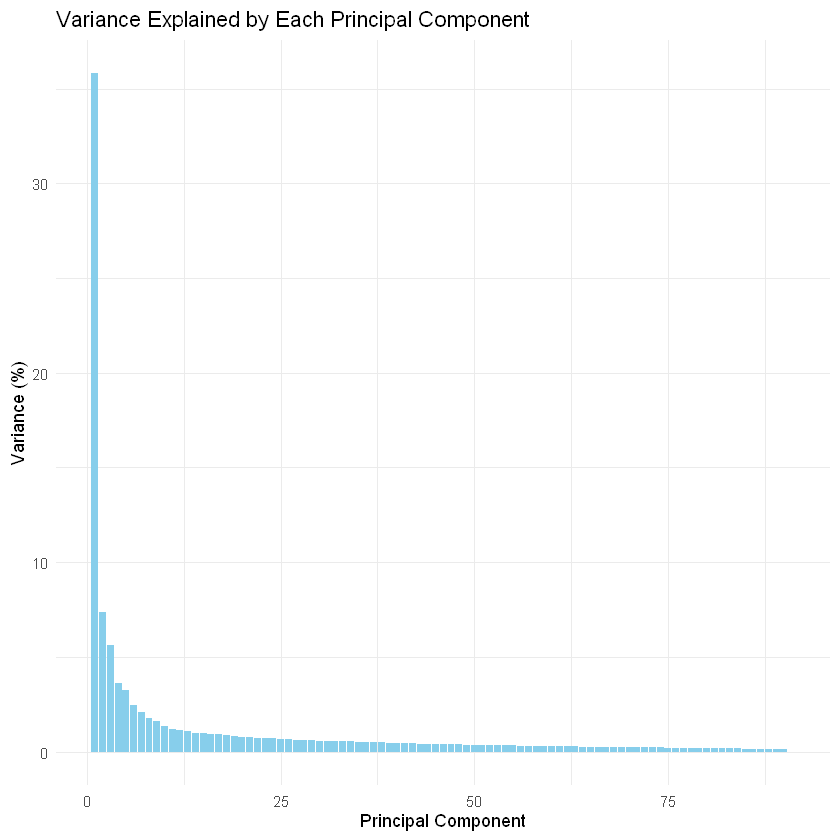

[1] "Current Time : 2024-12-09 10:57:54"
[1] "Standard PCA computation time : 0.153 seconds"


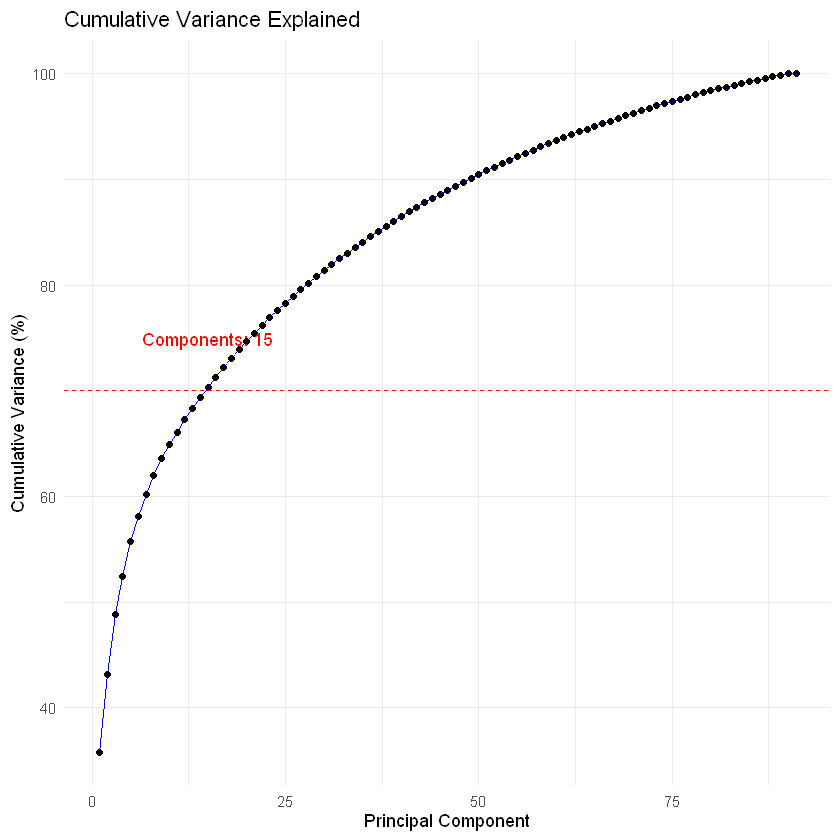

In [173]:
# PCA Exploration                        #
##########################################

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

oPCAAnalysis <- Analyze_PCA(oDataMatrix, numAxes = 15, explainedVarianceThreshold = 70)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

In [175]:
# Create the functions to compute the evaluation criteria

Get_RMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_RMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_RMSE() - Error : Input data contains NA value(s).")
  }
  return(sqrt(mean((rActual - rPredicted)^2, na.rm = TRUE)))
}

Get_MSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_MSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_MSE() - Error : Input data contains NA value(s).")
  }
  return(mean((rActual - rPredicted)^2, na.rm = TRUE))
}

Get_NMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_NMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_NMSE() - Error : Input data contains NA value(s).")
  }

  rMean_Squared_Error <- sum((rActual - rPredicted)^2)
  rMean_Variance_Error <- sum((rActual - mean(rActual))^2)

  if (rMean_Variance_Error == 0) {
    warning("Get_NMSE() - Error : Division / 0.")
    return(NA)
  }

  return(rMean_Squared_Error / rMean_Variance_Error)
}

# 4. Standard PCA

In [178]:
Perform_Standard_PCA <- function(trainData, testData, numComponents = NULL, varianceThreshold = NULL) {
  
  # Step 1: Select variables based on a variance threshold
  if (!is.null(varianceThreshold)) {
    colVariances <- apply(trainData, 2, var)  
    selectedCols <- colVariances > varianceThreshold
    trainData <- trainData[, selectedCols, drop = FALSE]
    testData <- testData[, selectedCols, drop = FALSE]
  } else {
    selectedCols <- rep(TRUE, ncol(trainData))
  }

  # Step 2: Define the number of components if not specified
  if (is.null(numComponents)) {
    numComponents <- ncol(trainData)
  }

  # Preprocessing: centering and scaling the training data
  X_train_scaled <- scale(trainData, center = TRUE, scale = TRUE)
  X_mean <- attr(X_train_scaled, "scaled:center")
  X_sd <- attr(X_train_scaled, "scaled:scale")

  # Perform PCA on the preprocessed data (not on the correlation matrix)
  # Since the data is already centered/scaled, set center=FALSE and scale.=FALSE in prcomp
  oPcaResult <- prcomp(X_train_scaled, center = FALSE, scale. = FALSE)

  # Visualization (optional)
  if (ncol(oPcaResult$x) >= 2) {
    plot(oPcaResult$x[, 1:2], main = "Standard PCA", xlab = "PC1", ylab = "PC2")
  }

  # Apply the same preprocessing to the test data
  X_test_scaled <- scale(testData, center = X_mean, scale = X_sd)

  # Project the test data onto the principal components
  # predict() can also be used directly, but here it's done manually:
  oTestScores <- X_test_scaled %*% oPcaResult$rotation[, 1:numComponents]

  # Reconstruct the test data
  X_test_reconstructed_scaled <- oTestScores %*% t(oPcaResult$rotation[, 1:numComponents])

  # Return to the original scale
  X_test_reconstructed <- sweep(X_test_reconstructed_scaled, 2, X_sd, "*")
  X_test_reconstructed <- sweep(X_test_reconstructed, 2, X_mean, "+")

  # Check dimensions
  if (!all(dim(X_test_reconstructed) == dim(testData))) {
    stop("Mismatch in dimensions between testData and reconstructed data")
  }

  # Evaluation
  dRMSE <- Get_RMSE(as.vector(testData), as.vector(X_test_reconstructed))
  dMSE <- Get_MSE(as.vector(testData), as.vector(X_test_reconstructed))
  dNMSE <- Get_NMSE(as.vector(testData), as.vector(X_test_reconstructed))

  result <- list(RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE)
  if (!is.null(varianceThreshold)) {
    result$ActiveVariables <- sum(selectedCols)
  } else {
    result$ActiveVariables <- numComponents
  }

  return(result)
}

[1] "Current Time : 2024-12-09 10:58:01"
[1] "Number of Components: 22"
[1] "Standard PCA - RMSE: 0.374795777287836"
[1] "Standard PCA - MSE: 0.140471874672793"
[1] "Standard PCA - NMSE: 0.0430019061009291"
[1] "Current Time : 2024-12-09 10:58:01"
[1] "Standard PCA computation time : 0.061 seconds"


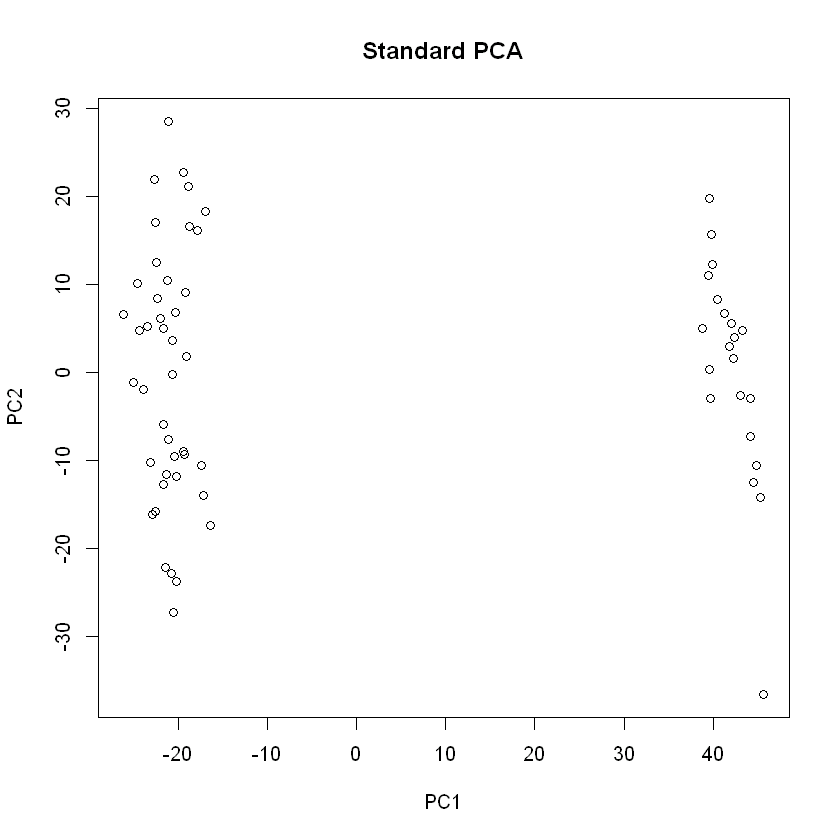

In [180]:
# Standard PCA on the Train DATASET      #
##########################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# First step => Find the number of components explaining 95% of the variance
oPCAResult <- prcomp(oTrainData, center = TRUE, scale. = TRUE)
dExplained_Variance <- cumsum(oPCAResult$sdev^2) / sum(oPCAResult$sdev^2)
iNumComponents <- which(dExplained_Variance >= 0.80)[1]
print(paste("Number of Components:", iNumComponents))

# Perform Standard PCA
oStandardPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, NULL)

print(paste("Standard PCA - RMSE:", oStandardPCAResults$RMSE))
print(paste("Standard PCA - MSE:", oStandardPCAResults$MSE))
print(paste("Standard PCA - NMSE:", oStandardPCAResults$NMSE))

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

# 5. PCA based on Variance Selection

[1] "Current Time : 2024-12-09 10:58:08"


$RMSE
[1] 0.7680762

$MSE
[1] 0.589941

$NMSE
[1] 0.1503045

$ActiveVariables
[1] 66

[1] "Current Time : 2024-12-09 10:58:08"
[1] "Variance Selection PCA computation time : 0.019 seconds"


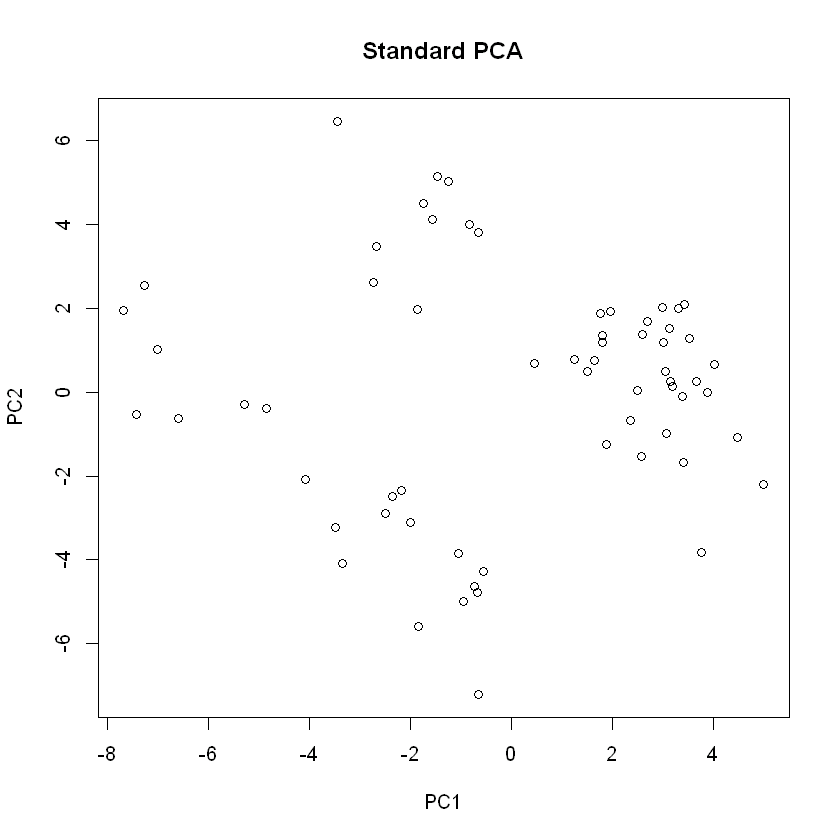

In [183]:
# Variance Selection PCA on the Train DATASET      #
####################################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Perform Variance Selection PCA
oVarPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, varianceThreshold = 1)

oVarPCAResults

# Display end time and elapsed time
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Variance Selection PCA computation time :", elapsed_time, "seconds"))

# 6. Sparse PCA

In [186]:
Perform_Sparse_PCA <- function(trainData, testData, paraValues, numComponents = 1) {
  library(elasticnet)
  
  # Data frame to store numeric results
  results <- data.frame(Para = paraValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # List to store loadings for each para value
  loadings_list <- list()
  
  # Parallel execution
  parallel_results <- foreach(i = 1:length(paraValues), .combine = rbind,
                              .packages = c("elasticnet"), 
                              .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    iPara <- paraValues[i]

    # HERE THE CALL WITH PRE-TREATMENT. Cor Matrix Sended to the fonction.
    # Preprocessing: scale trainData and compute covariance matrix
    X <- scale(trainData, center = TRUE, scale = TRUE)
    S <- cor(X)  # Matrice de corrélation
    # Perform Sparse PCA using the covariance matrix and type = "Gram"
    oSparsePcaResult <- spca(S, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents), type = "Gram")

    # HERE THE CALL WITH RAW DATA      
    # oSparsePcaResult <- spca(trainData, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents))

      
    if (!is.null(oSparsePcaResult$loadings)) {
      # Scale testData with the same parameters used for trainData
      testDataScaled <- scale(testData, 
                              center = attr(X, "scaled:center"), 
                              scale = attr(X, "scaled:scale"))
      
      # Compute scores for test data in scaled space
      oTestScores <- testDataScaled %*% oSparsePcaResult$loadings
      
      # Reconstruct scaled test data
      oReconstructedScaled <- oTestScores %*% t(oSparsePcaResult$loadings)
      
      # Unscale the reconstructed data to original scale
      # First multiply by scale, then add center back
      oReconstructedData <- sweep(oReconstructedScaled, 2, attr(X, "scaled:scale"), "*")
      oReconstructedData <- sweep(oReconstructedData, 2, attr(X, "scaled:center"), "+")

      # Evaluate metrics using the original testData scale
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedData))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedData))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedData))
      
      # Count non-zero loadings
      non_zero_loadings <- sum(oSparsePcaResult$loadings != 0)
      
      cat("Para =", iPara, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Non-zero loadings:", non_zero_loadings, "\n")
      
      # Return iteration results
      data.frame(Para = iPara, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = non_zero_loadings)
    } else {
      cat("Para =", iPara, "- No valid loadings returned by spca\n")
      data.frame(Para = iPara, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
    }
  }
  
  # After parallel execution, we need to retrieve loadings in sequential mode.
  # If you want consistent results, use the same approach (covariance matrix + type = "Gram") here as well.
  X <- scale(trainData, center = TRUE, scale = TRUE)
  S <- cov(X)
  for (iPara in paraValues) {
    oSparsePcaResult <- spca(S, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents), type = "Gram")
    if (!is.null(oSparsePcaResult$loadings)) {
      loadings_list[[as.character(iPara)]] <- oSparsePcaResult$loadings
    } else {
      loadings_list[[as.character(iPara)]] <- NULL
    }
  }
  
  results <- parallel_results
  
  # Return a list containing the results data frame and the loadings list
  return(list(results = results, loadings = loadings_list))
}

In [188]:
##########################################
# Sparse PCA on the entire Train DATASET #
##########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Penalty list
oParaValues <- c(1, 2, 3, 5, 10, 15, 20, 25, 30)

#oParaValues <- c(10)

# Perform Sparse PCA
res <- Perform_Sparse_PCA(oTrainData, oTestData, oParaValues, numComponents = 1)

oSparsePCAResults <- res$results
loadings_list <- res$loadings


print(oSparsePCAResults[, -6])

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-09 10:58:11"
  Para      RMSE       MSE       NMSE ActiveVariables
1    1 0.5506318 0.3031954 0.09281558              48
2    2 0.5513815 0.3040216 0.09306851              37
3    3 0.5516967 0.3043692 0.09317492              32
4    5 0.5519663 0.3046668 0.09326602              27
5   10 0.5519394 0.3046371 0.09325693              20
6   15 0.5525208 0.3052793 0.09345351              15
7   20 0.5530588 0.3058740 0.09363558              13
8   25 0.5534526 0.3063098 0.09376897               6
9   30 0.5539601 0.3068717 0.09394101               6
[1] "Current Time : 2024-12-09 11:10:19"
[1] "Sparse PCA computation time : 727.269 seconds"


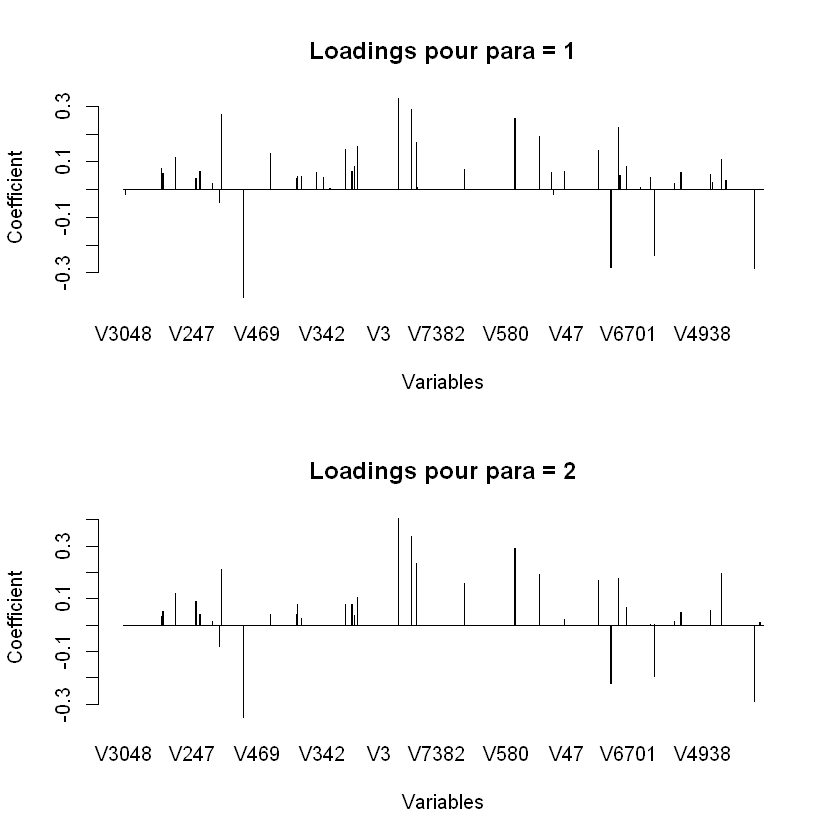

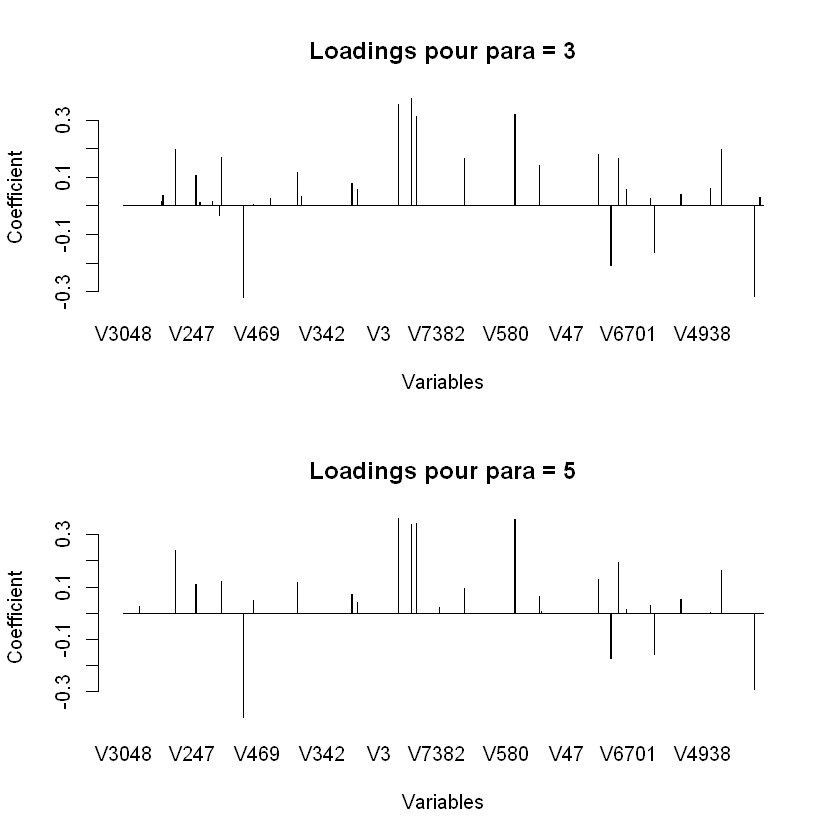

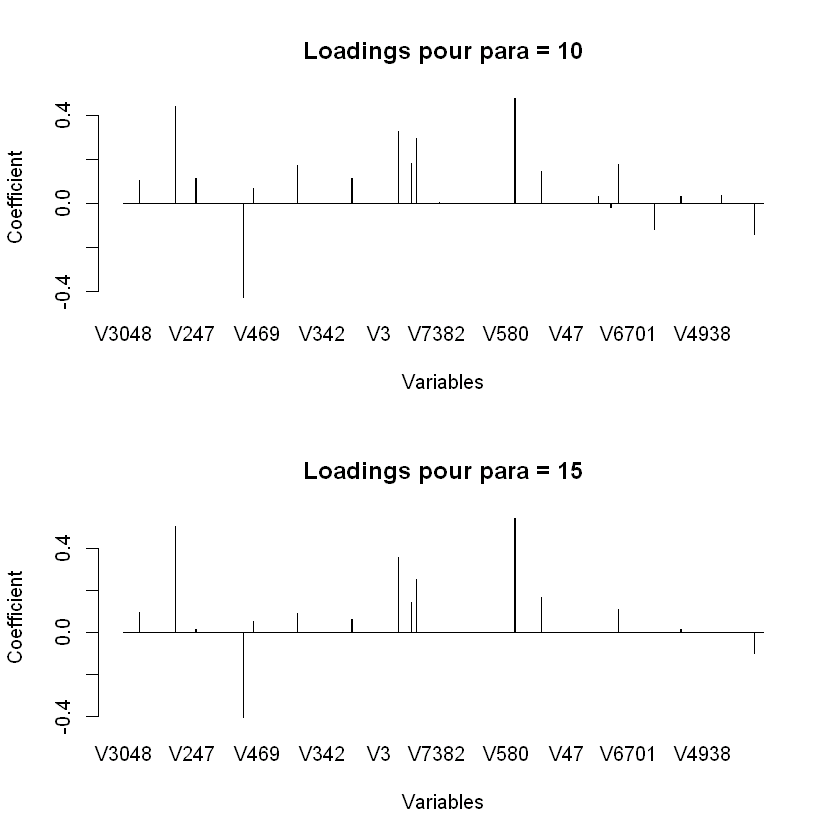

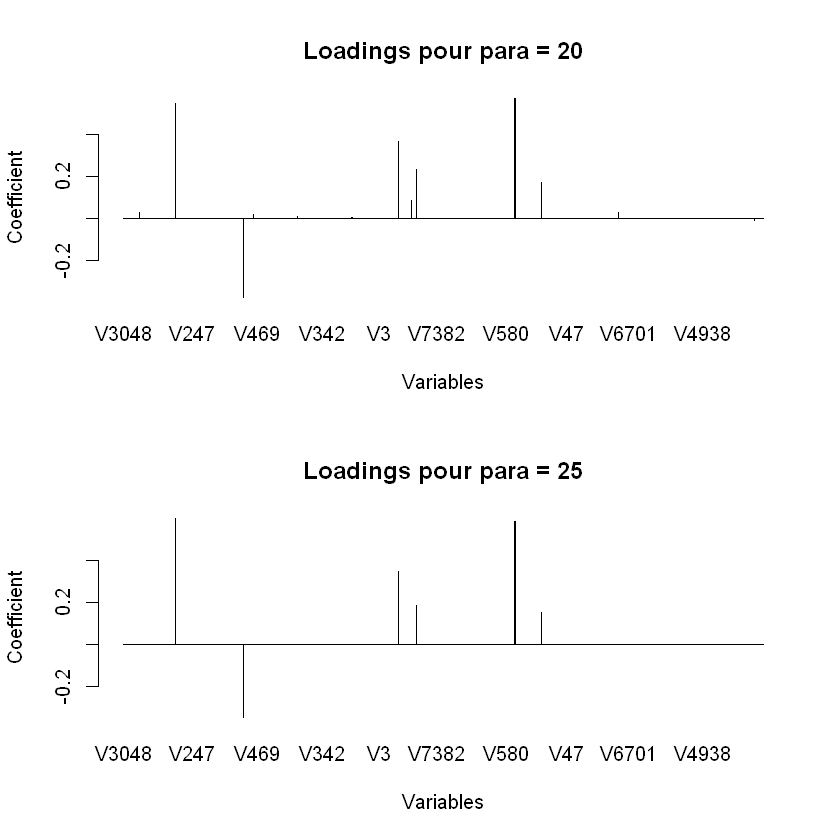

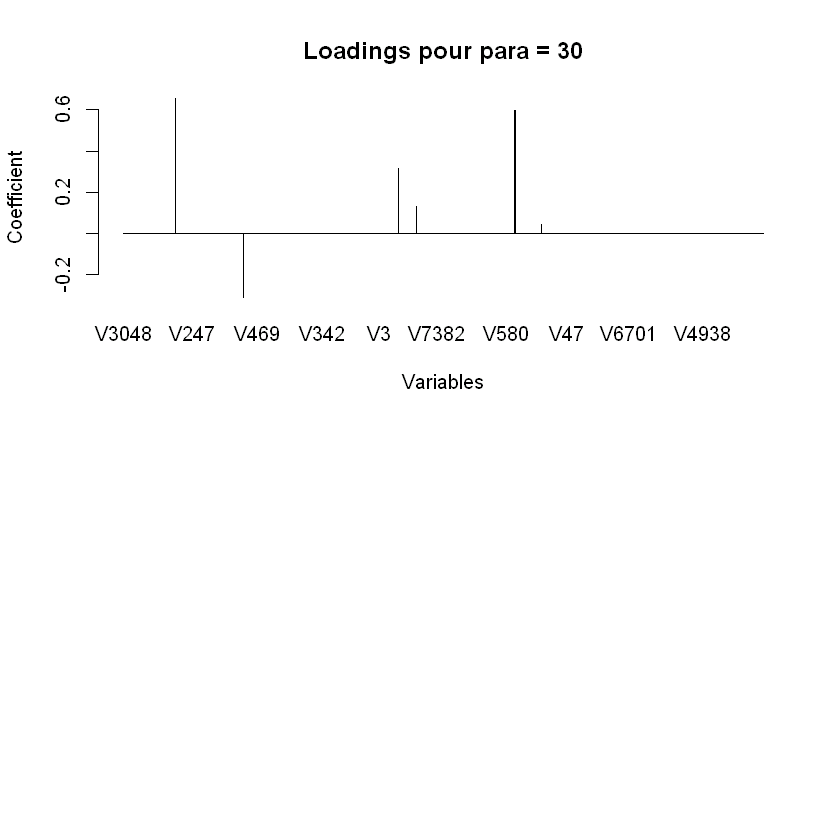

In [190]:
##########################################
# Sparse PCA Loadings Visual             #
##########################################

par(mfrow = c(ceiling(length(oParaValues)/6), 1))

for (iPara in oParaValues) {
  loadings <- loadings_list[[as.character(iPara)]]
  
  if (!is.null(loadings)) {
    barplot(loadings[, 1], main = paste("Loadings pour para =", iPara),
            xlab = "Variables", ylab = "Coefficient")
  } else {
    plot.new()
    title(main = paste("Pas de loadings pour para =", iPara))
  }
}

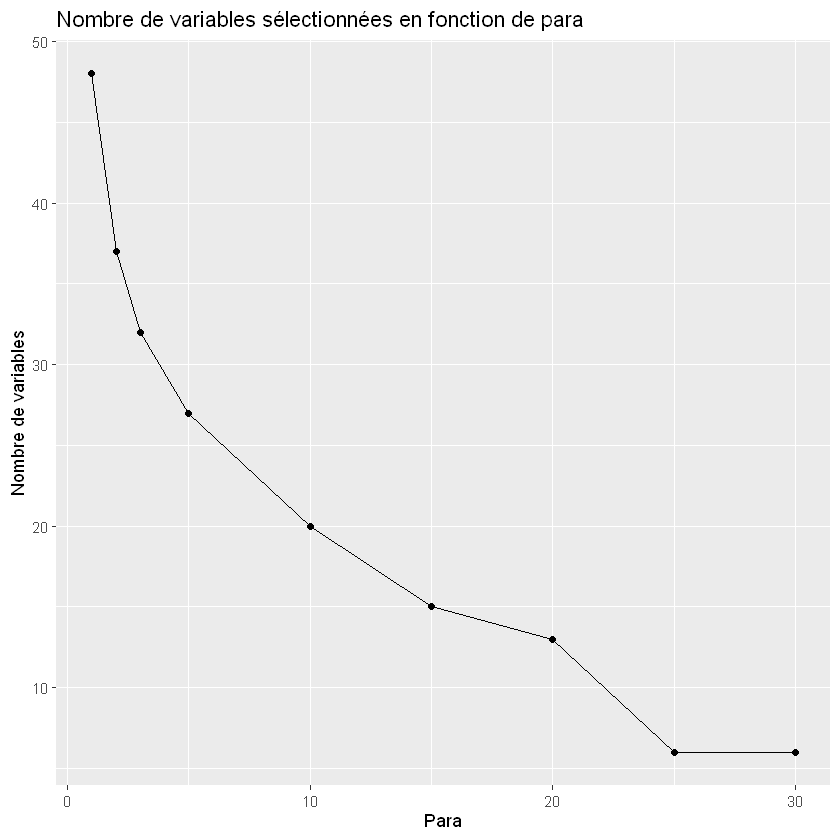

In [192]:
ggplot(oSparsePCAResults, aes(x = Para, y = ActiveVariables)) +
  geom_point() +
  geom_line() +
  labs(title = "Nombre de variables sélectionnées en fonction de para", x = "Para", y = "Nombre de variables")

In [194]:
# Sparse PCA : Showing the best result  #
#########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

library(elasticnet)

variances <- apply(oTrainData, 2, var)

k <- 60 # Varaiables to keep
top_var_indices <- order(variances, decreasing = TRUE)[1:k]
x_reduced <- oTrainData[, top_var_indices]  # Jeu de données réduit

pca_sparse <- prcomp(x_reduced, center = TRUE, scale. = TRUE)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-09 11:14:09"
[1] "Current Time : 2024-12-09 11:14:09"
[1] "Sparse PCA computation time : 0.021 seconds"


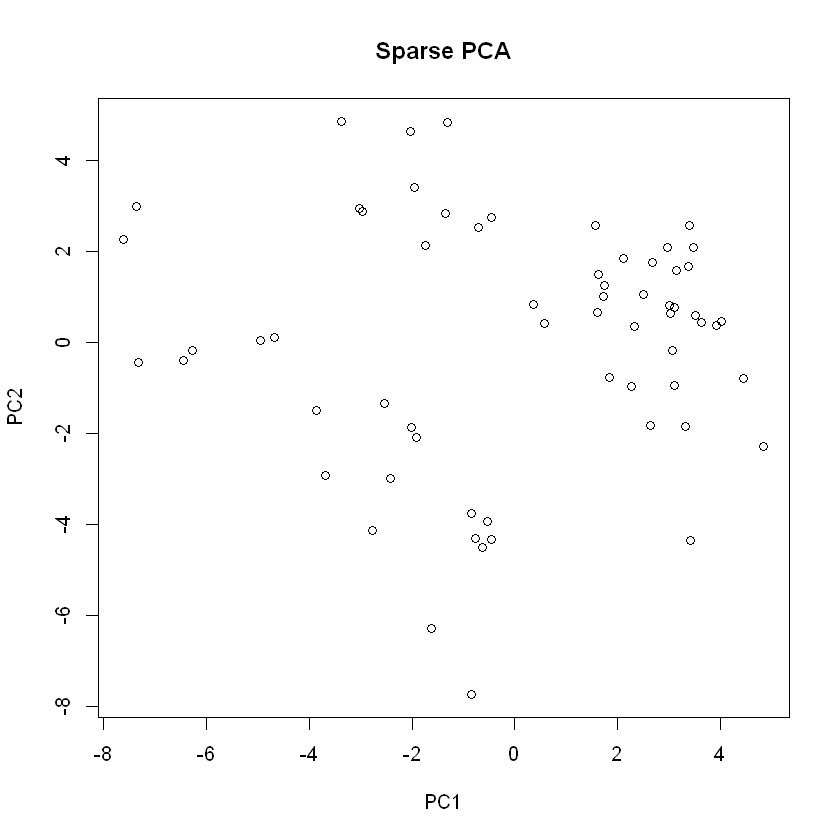

In [196]:
plot(pca_sparse$x[, 1:2], main = "Sparse PCA",
     xlab = "PC1", ylab = "PC2")

# THRESHOLD PCA

In [199]:
Perform_Threshold_PCA <- function(trainData, testData, thresholdValues, numComponents = 1) {
  results <- data.frame(Threshold = thresholdValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # Parallel execution with exported functions
  results <- foreach(i = 1:length(thresholdValues), .combine = rbind, 
                     .packages = c("stats"), 
                     .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    dThreshold <- thresholdValues[i]
    
    # Selecting variables with variance above the threshold
    oVariances <- apply(trainData, 2, var)
    oSelectedIndices <- which(oVariances > dThreshold)
    ActiveVariables <- length(oSelectedIndices)
    
    if (ActiveVariables > 0) {
      # Subset of selected variables
      oTrainDataSelected <- trainData[, oSelectedIndices, drop = FALSE]
      oTestDataSelected <- testData[, oSelectedIndices, drop = FALSE]

      # Centering and scaling on the selected training data
      X_train_selected_scaled <- scale(oTrainDataSelected, center = TRUE, scale = TRUE)
      X_mean <- attr(X_train_selected_scaled, "scaled:center")
      X_sd <- attr(X_train_selected_scaled, "scaled:scale")

      # PCA on the preprocessed selected data
      # Set center=FALSE, scale.=FALSE since centering/scaling is done manually
      oPcaResult <- prcomp(X_train_selected_scaled, center = FALSE, scale. = FALSE)

      # Apply the same preprocessing to the selected test data
      X_test_selected_scaled <- scale(oTestDataSelected, center = X_mean, scale = X_sd)
      
      # Project test data onto principal components
      oTestScores <- X_test_selected_scaled %*% oPcaResult$rotation[, 1:min(numComponents, ActiveVariables), drop = FALSE]

      # Reconstruct in scaled form
      X_test_reconstructed_selected_scaled <- oTestScores %*% t(oPcaResult$rotation[, 1:min(numComponents, ActiveVariables), drop = FALSE])

      # Return to the original scale for the selected subset
      X_test_reconstructed_selected <- sweep(X_test_reconstructed_selected_scaled, 2, X_sd, "*")
      X_test_reconstructed_selected <- sweep(X_test_reconstructed_selected, 2, X_mean, "+")

      # Place the reconstructed subset back into the full matrix (non-selected variables = 0)
      oReconstructedFull <- matrix(0, nrow = nrow(testData), ncol = ncol(testData))
      oReconstructedFull[, oSelectedIndices] <- X_test_reconstructed_selected

      # Evaluation
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedFull))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedFull))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedFull))
      
      # Store results
      result_row <- data.frame(Threshold = dThreshold, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = ActiveVariables)
      
      cat("Threshold =", dThreshold, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Num Variables:", ActiveVariables, "\n")
    } else {
      cat("Threshold =", dThreshold, "- No variables selected\n")
      result_row <- data.frame(Threshold = dThreshold, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = 0)
    }
    
    result_row
  }
  
  return(results)
}

In [201]:
# Threshold PCA on the entire DATASET 01   #
############################################

# Cell execution time 15/11/2024 : 13.563 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Threshold list
thresholdValues <- seq(0.05, 1.5, by = 0.05)

# Perform Threshold PCA
oThresholdPCAResults <- Perform_Threshold_PCA(oTrainData, oTestData, thresholdValues, numComponents = 1)

print(oThresholdPCAResults)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Threshold PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-09 11:14:16"
   Threshold     RMSE       MSE      NMSE ActiveVariables
1       0.05 2.441222  5.959564  1.824370            2127
2       0.10 3.914328 15.321961  4.690430            1663
3       0.15 4.984588 24.846119  7.606010            1274
4       0.20 5.664872 32.090776  9.823778             996
5       0.25 6.169143 38.058329 11.650593             759
6       0.30 6.498443 42.229758 12.927571             596
7       0.35 6.776818 45.925262 14.058856             462
8       0.40 6.930917 48.037611 14.705498             380
9       0.45 7.059670 49.838944 15.256930             314
10      0.50 7.186681 51.648381 15.810844             249
11      0.55 7.268934 52.837404 16.174833             205
12      0.60 7.322700 53.621929 16.414995             174
13      0.65 7.365314 54.247850 16.606605             149
14      0.70 7.397103 54.717129 16.750263             131
15      0.75 7.428176 55.177792 16.891283             114
16      0.80 7.449409 55.493689

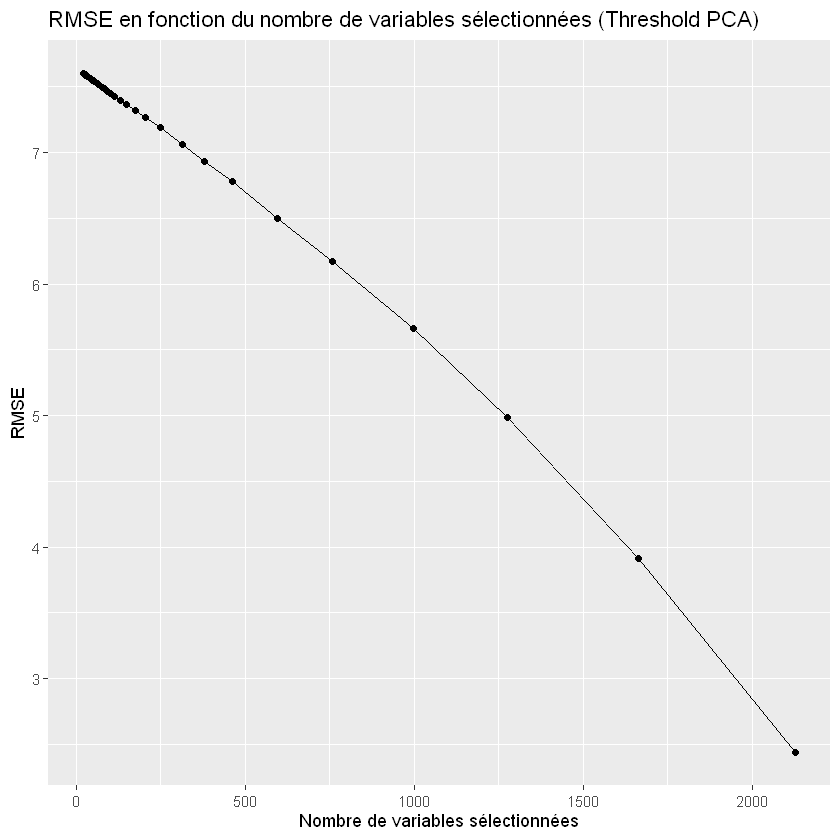

In [203]:
ggplot(oThresholdPCAResults, aes(x = ActiveVariables, y = RMSE)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE en fonction du nombre de variables sélectionnées (Threshold PCA)",
       x = "Nombre de variables sélectionnées", y = "RMSE")

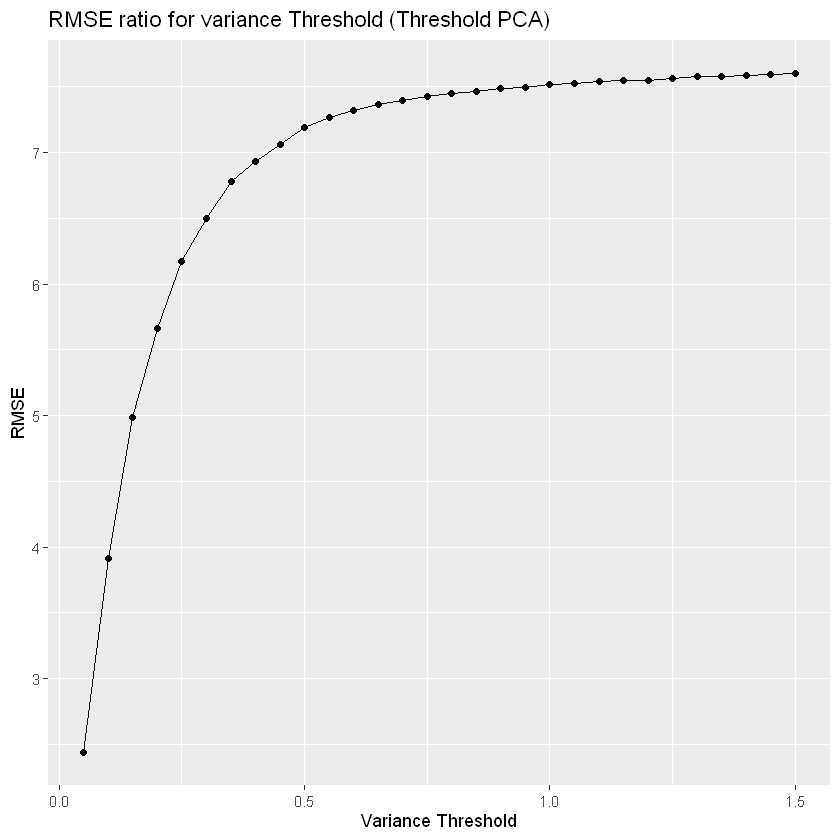

In [205]:
ggplot(oThresholdPCAResults, aes(x = Threshold, y = RMSE)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE ratio for variance Threshold (Threshold PCA)",
       x = "Variance Threshold", y = "RMSE")

# 7. RESULTS

In [208]:
# Merging results array                 #
#########################################

library(reshape2)
library(tidyr)

# Convert named lists to numeric values
oStandardPCAResults$RMSE <- as.numeric(oStandardPCAResults$RMSE)
oStandardPCAResults$MSE <- as.numeric(oStandardPCAResults$MSE)
oStandardPCAResults$NMSE <- as.numeric(oStandardPCAResults$NMSE)
oVarPCAResults$RMSE <- as.numeric(oVarPCAResults$RMSE)
oVarPCAResults$MSE <- as.numeric(oVarPCAResults$MSE)
oVarPCAResults$NMSE <- as.numeric(oVarPCAResults$NMSE)
oSparsePCAResults$RMSE <- sapply(oSparsePCAResults$RMSE, as.numeric)
oSparsePCAResults$MSE <- sapply(oSparsePCAResults$MSE, as.numeric)
oSparsePCAResults$NMSE <- sapply(oSparsePCAResults$NMSE, as.numeric)
oThresholdPCAResults$RMSE <- sapply(oThresholdPCAResults$RMSE, as.numeric)
oThresholdPCAResults$MSE <- sapply(oThresholdPCAResults$MSE, as.numeric)
oThresholdPCAResults$NMSE <- sapply(oThresholdPCAResults$NMSE, as.numeric)

# New data frames
standardPCAResultsDF <- data.frame(Method = "Standard PCA", Parameter = 0, 
                                   RMSE = round(oStandardPCAResults$RMSE, 4), 
                                   MSE = round(oStandardPCAResults$MSE, 4), 
                                   NMSE = round(oStandardPCAResults$NMSE, 4),
                                   ActiveVariables = unlist(oStandardPCAResults$ActiveVariables))

variancePCAResultsDF <- data.frame(Method = "Variance PCA", Parameter = 0, 
                                   RMSE = round(oVarPCAResults$RMSE, 4), 
                                   MSE = round(oVarPCAResults$MSE, 4), 
                                   NMSE = round(oVarPCAResults$NMSE, 4),
                                   ActiveVariables = unlist(oVarPCAResults$ActiveVariables))

sparsePCAResultsDF <- data.frame(Method = "Sparse PCA", Parameter = oSparsePCAResults$Para, 
                                 RMSE = round(unlist(oSparsePCAResults$RMSE), 4), 
                                 MSE = round(unlist(oSparsePCAResults$MSE), 4), 
                                 NMSE = round(unlist(oSparsePCAResults$NMSE), 4),
                                 ActiveVariables = unlist(oSparsePCAResults$ActiveVariables))

thresholdPCAResultsDF <- data.frame(Method = "Threshold PCA", Parameter = oThresholdPCAResults$Threshold, 
                                    RMSE = round(unlist(oThresholdPCAResults$RMSE), 4), 
                                    MSE = round(unlist(oThresholdPCAResults$MSE), 4), 
                                    NMSE = round(unlist(oThresholdPCAResults$NMSE), 4),
                                    ActiveVariables = unlist(oThresholdPCAResults$ActiveVariables))                                    

# Combine all results
allResults <- rbind(standardPCAResultsDF, variancePCAResultsDF, sparsePCAResultsDF, thresholdPCAResultsDF)

# Cleaning
allResults$Parameter <- replace_na(allResults$Parameter, 0)

# Calculate Global_Score with rounded values
allResults <- allResults %>%
  mutate(Global_Score = round((RMSE + MSE + NMSE) / 3, 4))

print(allResults)

          Method Parameter   RMSE     MSE    NMSE ActiveVariables Global_Score
1   Standard PCA      0.00 0.3748  0.1405  0.0430              22       0.1861
2   Variance PCA      0.00 0.7681  0.5899  0.1503              66       0.5028
3     Sparse PCA      1.00 0.5506  0.3032  0.0928              48       0.3155
4     Sparse PCA      2.00 0.5514  0.3040  0.0931              37       0.3162
5     Sparse PCA      3.00 0.5517  0.3044  0.0932              32       0.3164
6     Sparse PCA      5.00 0.5520  0.3047  0.0933              27       0.3167
7     Sparse PCA     10.00 0.5519  0.3046  0.0933              20       0.3166
8     Sparse PCA     15.00 0.5525  0.3053  0.0935              15       0.3171
9     Sparse PCA     20.00 0.5531  0.3059  0.0936              13       0.3175
10    Sparse PCA     25.00 0.5535  0.3063  0.0938               6       0.3179
11    Sparse PCA     30.00 0.5540  0.3069  0.0939               6       0.3183
12 Threshold PCA      0.05 2.4412  5.9596  1.8244   

In [ ]:
library(dplyr)
library(ggplot2)


sortedResults <- allResults %>%
  arrange(NMSE) 


print(sortedResults)


bestMethod <- sortedResults %>%
  slice(1) 

cat("The best method is:", bestMethod$Method, "with a NMSE of", bestMethod$NMSE, "\n")

In [ ]:
bestResults <- allResults %>%
  group_by(Method) %>%
  filter(NMSE == min(NMSE, na.rm = TRUE)) %>%
  slice(1) %>%
  ungroup()

print(bestResults)

ggplot(bestResults, aes(x = reorder(Method, NMSE), y = NMSE, fill = Method)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Best NMSE for Each PCA Method",
    x = "PCA Method",
    y = "Normalized Mean Squared Error (NMSE)"
  ) +
  theme_minimal() +
  theme(legend.position = "none") +
  geom_text(aes(label = round(NMSE, 4)), vjust = -0.5, size = 3)

In [ ]:
ggplot(allResults, aes(x = Parameter, y = RMSE, color = Method)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE for PCA Methods", x = "(para or threshold)", y = "RMSE")

In [ ]:
# Computing a score                     #
#########################################

summaryDF <- allResults %>%
  group_by(Method) %>%
  summarise(
    Mean_RMSE = mean(RMSE),
    Mean_MSE = mean(MSE),
    Mean_NMSE = mean(NMSE)
  )

summaryDF <- summaryDF %>%
  mutate(Global_Score = (Mean_RMSE + Mean_MSE + Mean_NMSE) / 3)

print(summaryDF %>% arrange(Global_Score))  # Sorted by best global score...

In [ ]:
library(tidyr)

allResultsLong <- allResults %>%
  pivot_longer(cols = c("RMSE", "MSE", "NMSE"), names_to = "Metric", values_to = "Value")

ggplot(allResultsLong, aes(x = Parameter, y = Value, color = Method)) +
  geom_line(aes(linetype = Metric)) +
  geom_point() +
  labs(title = "Performance Metrics by PCA Method and Parameter",
       x = "Parameter Value",
       y = "Metric Value (Lower is Better)") +
  theme_minimal()

In [ ]:
library(dplyr)
library(ggplot2)

# Compute vertical scale
global_min <- min(allResults$Global_Score, na.rm = TRUE)
global_max <- max(allResults$Global_Score, na.rm = TRUE)

ggplot(allResults, aes(x = Parameter, y = Global_Score)) +
  geom_line(aes(group = Method), color = "blue") +
  geom_point(color = "blue") +
  geom_hline(data = allResults %>% filter(Method == "Standard PCA"),
             aes(yintercept = Global_Score), linetype = "dashed", color = "red") +
  facet_wrap(~ Method, scales = "free_x") +
  labs(title = "Global Performance Score by PCA Method",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal() +
  coord_cartesian(ylim = c(global_min, global_max))


In [ ]:
# Standard PCA
standardPCA <- allResults %>% filter(Method == "Standard PCA")

ggplot(standardPCA, aes(x = Parameter, y = Global_Score)) +
  geom_hline(aes(yintercept = Global_Score), color = "blue") +
  labs(title = "Global Performance Score - Standard PCA",
       x = "Parameter (Fixed at 0)",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

In [ ]:
# Sparse PCA
sparsePCA <- allResults %>% filter(Method == "Sparse PCA")
ggplot(sparsePCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "darkgreen") +
  geom_point(color = "darkgreen") +
  labs(title = "Global Performance Score by Parameter - Sparse PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

# Threshold PCA
thresholdPCA <- allResults %>% filter(Method == "Threshold PCA")
ggplot(thresholdPCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "purple") +
  geom_point(color = "purple") +
  labs(title = "Global Performance Score by Parameter - Threshold PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


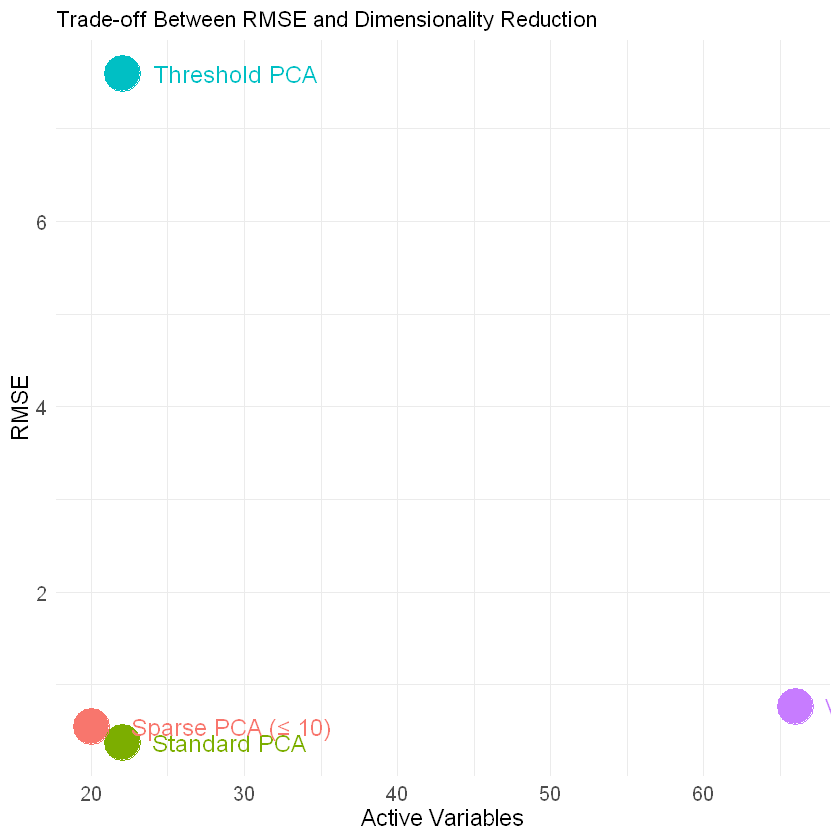

In [212]:
library(ggplot2)

data_cancer <- data.frame(
  Method = c("Standard PCA", "Variance PCA", "Sparse PCA (≤ 10)", "Threshold PCA"),
  RMSE = c(0.3748, 0.7681, 0.5516, 7.5976),
  ActiveVariables = c(22, 66, 20, 22)
)

ggplot(data_cancer, aes(x = ActiveVariables, y = RMSE, color = Method)) +
  geom_line(size = 1.2, show.legend = FALSE) + 
  geom_point(size = 10) +  
  geom_text(aes(label = Method), hjust = -0.2, vjust = 0.5, size = 5) +
  labs(
    title = "Trade-off Between RMSE and Dimensionality Reduction",
    x = "Active Variables",
    y = "RMSE",
    color = "Method"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )


In [214]:
ggsave(
  filename = "PCA_Cancer_Tradeoff.jpg",
  plot = last_plot(),
  device = "jpeg",
  width = 10,
  height = 7,
  dpi = 300
)


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
